In [1]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\geogeo\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [1]:
import cv2
from scipy.signal import convolve2d
import numpy as np
import os
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.fft import dctn, idctn
from scipy.io import loadmat
import pandas as pd

In [2]:
from utils.fonctions import lightDirection, lightsDirection, getI

In [3]:
data = loadmat('./data/vase/vase_mat_3.mat')

In [4]:
I = data["I"]
S = data["S"]
masque = data["masque"]
Z = data["Z"]
N = data["N"]

In [5]:
masque_ = masque.flatten("F")
masque= np.reshape(masque_, masque.shape)

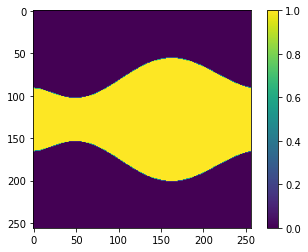

In [6]:
plt.imshow(masque, cmap='viridis')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

In [7]:
exterieur = masque.flatten() == 0
exterieur= np.reshape(exterieur, masque.shape)

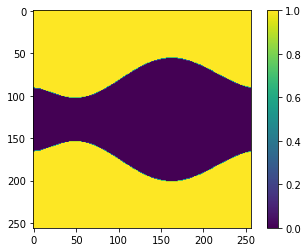

In [8]:
plt.imshow(exterieur, cmap='viridis')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

In [9]:
[nb_lignes, nb_colonnes] = masque.shape
[n,p] = I.shape

In [10]:
def stereophotometrie(I,S,masque=None):
    pseudo_inverse_S = np.linalg.pinv(S)
    m = pseudo_inverse_S @ I


    rho_estime = np.sqrt(np.sum(np.square(m), 0))
    N_estime = m / (rho_estime + 1e-3)
    N_estime[:, masque.flatten() == 0] = 0

    return rho_estime, N_estime

In [11]:
rho_estime, N_estime = stereophotometrie(I,S,masque)

In [12]:
N_estime[2, exterieur.flatten()] = 1

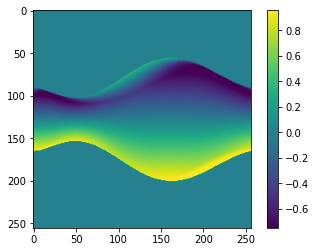

In [13]:
plt.imshow(np.reshape(N_estime[0, :], masque.shape), cmap='viridis')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

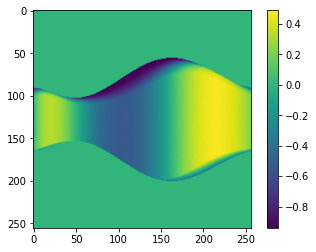

In [14]:
plt.imshow(np.reshape(N_estime[1, :], masque.shape), cmap='viridis')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

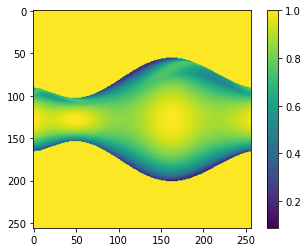

In [15]:
plt.imshow(np.reshape(N_estime[2, :], masque.shape), cmap='viridis')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

In [54]:
p_estime = np.reshape(-N_estime[0, :] / N_estime[2, :], masque.shape)
p_estime[exterieur] = 0
q_estime = np.reshape(-N_estime[1, :] / N_estime[2, :], masque.shape)
q_estime[exterieur] = 0

In [55]:
def integrationSCS(p, q, gt=None):
    # Compute div(p,q)

    gradient_p, gradient_q = np.gradient(p), np.gradient(q)
    f = gradient_p[0] + gradient_q[1]
    
    f[0, 1:-1] = 0.5 * (p[0, 1:-1] + p[1, 1:-1])
    f[-1, 1:-1] = 0.5 * (-p[-1, 1:-1] - p[-2, 1:-1])
    f[1:-1, 0] = 0.5 * (q[1:-1, 0] + q[1:-1, 1])
    f[1:-1, -1] = 0.5 * (-q[1:-1, -1] - q[1:-1, -2])

    f[0, 0] = 0.5 * (p[0, 0] + p[1, 0] + q[0, 0] + q[0, 1])
    f[-1, 0] = 0.5 * (-p[-1, 0] - p[-2, 0] + q[-1, 0] + q[-1, 1])
    f[0, -1] = 0.5 * (p[0, -1] + p[1, -1] - q[0, -1] - q[0, -2])
    f[-1, -1] = 0.5 * (-p[-1, -1] - p[-2, -1] - q[-1, -1] - q[-1, -2])

    # Cosine Transform of f
    fsin = dctn(f, norm='ortho')
    print(fsin.shape)
    print(fsin)

    # Denominator
    x, y = np.meshgrid(np.arange(p.shape[1]), np.arange(p.shape[0]))
    denom = (2 * np.cos(np.pi * x / p.shape[1]) - 2) + (2 * np.cos(np.pi * y / p.shape[0]) - 2)
    Z_ = fsin / denom
    Z_[0, 0] = 0.5 * (Z_[0, 1] + Z_[1, 0])

    # Inverse Cosine Transform
    U = idctn(Z_, norm='ortho')

    if gt is not None:
        moyenne_ecarts = np.mean(U - gt)
        U -= moyenne_ecarts
        npix = p.shape[0] * p.shape[1]
        rmse = np.sqrt(np.sum((U - gt) ** 2) / npix)
        return U, rmse
    else:
        U -= np.min(U)
        return U

In [56]:
z_estime = integrationSCS(p_estime, q_estime)

(256, 256)
[[ 5.64251977e-17  3.91767469e-01  6.24512188e-01 ... -1.15641562e-03
  -2.78825877e-03  7.35689029e-04]
 [-2.72691732e-01  1.29104068e-01  1.80918943e-01 ...  1.59377707e-03
  -2.37138979e-03 -1.89769159e-03]
 [ 1.64530749e+00 -9.99694127e-01 -1.03199250e+00 ...  4.00891582e-06
   1.74469474e-03  3.38097018e-04]
 ...
 [-4.60285859e-03  6.31444771e-03 -5.39128519e-03 ... -2.20588305e-03
  -1.27665816e-03 -7.37035201e-04]
 [-8.96930456e-04  1.34977240e-03  1.07573607e-03 ...  1.40671526e-03
   1.67224791e-03 -9.27121593e-04]
 [ 2.11679217e-03  1.38905549e-03 -3.95699845e-03 ...  4.02772954e-03
   3.20998079e-03  1.63606299e-04]]


C:\Users\geogeo\AppData\Local\Temp\ipykernel_10076\3492765441.py:25: RuntimeWarning:

divide by zero encountered in divide



In [57]:
nb_lignes, nb_colonnes = z_estime.shape
mid_row = np.floor(nb_lignes / 2).astype(int)
mid_col = np.floor(nb_colonnes / 2).astype(int)

# Vérification de la condition et modification du tableau z_estime si nécessaire
if z_estime[mid_row, mid_col] < z_estime[1, 1]:
    z_estime = -z_estime
z_estime[exterieur] = 0

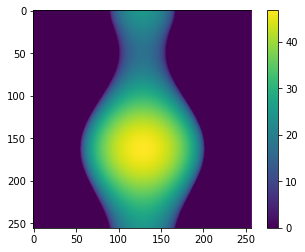

In [58]:
plt.imshow(Z, cmap='viridis')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

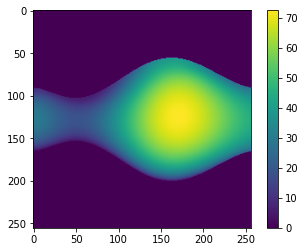

In [59]:
plt.imshow(z_estime, cmap='viridis')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

In [48]:
EA = np.degrees(np.arccos(np.sum(N * N_estime, 0)))
EA = np.reshape(EA, masque.shape)
np.mean(EA[masque == 1])

5.587507070202334

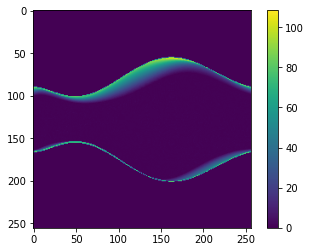

In [49]:
plt.imshow(EA, cmap='viridis')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

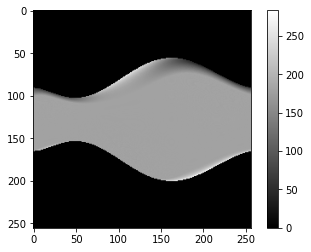

In [50]:
rho_estime = rho_estime.reshape(masque.shape)
plt.imshow(rho_estime, cmap='gray')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

In [51]:
import plotly.graph_objects as go

In [52]:
x, y = np.meshgrid(np.arange(z_estime.shape[1]), np.arange(z_estime.shape[0]))

In [53]:
fig = go.Figure(data=[go.Surface(z=z_estime, x=x, y=y)])
fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=0.7), 
                             xaxis=dict(title='X'),
                             yaxis=dict(title='Y'),
                             zaxis=dict(title='Z')))
fig.show()